In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
from sklearn.neural_network import MLPRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import VarianceThreshold

%matplotlib inline

In [98]:
# Read csv file, convert time to datetime data type
df = pd.read_csv('flex_networks.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'], infer_datetime_format=True)

In [99]:
# Predictors are DoW and HoD
times = df['Timestamp']
DoW = []
HoD = []
MoY = []

for x in times:
    DoW.append(x.weekday())
    HoD.append(x.hour)
    MoY.append(x.month)

df['DoW'] = DoW
df['HoD'] = HoD
df['MoY'] = MoY

In [100]:
targetColumn = ['crawfordCrescent_F2']
predictors = list(df.columns)[23:]
df[predictors] = df[predictors]/df[predictors].max()

In [101]:
X = df[predictors].values
y = df[targetColumn].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=40)
print(X_train.shape)
print(X_test.shape)

(12264, 10)
(5256, 10)


In [102]:
mlp = MLPRegressor(hidden_layer_sizes=(10,10,10), activation='relu', solver='adam', max_iter=500)
mlp.fit(X_train,y_train)

predict_train = mlp.predict(X_train)
predict_test = mlp.predict(X_test)

d:\Programs\Python\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [103]:
d = 200
l = d*48
h = d*48 + 3*48

preds = mlp.predict(df[predictors])


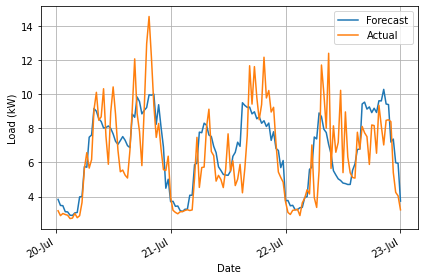

In [104]:
fig, ax = plt.subplots()
ax.plot(df["Timestamp"].iloc[l:h], preds[l:h], label="Forecast")
ax.plot(df["Timestamp"].iloc[l:h], df["crawfordCrescent_F2"].iloc[l:h], label="Actual")
# Major ticks every day
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.grid(True)
# Set labels to day number - month name
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
# Rotates and right-aligns the x labels so they don't crowd each other.
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
ax.set_ylabel("Load (kW)")
ax.set_xlabel("Date")
ax.legend()

plt.tight_layout()
#plt.savefig("pers_forecast.jpg", dpi=300, bbox_inches="tight")
plt.show()

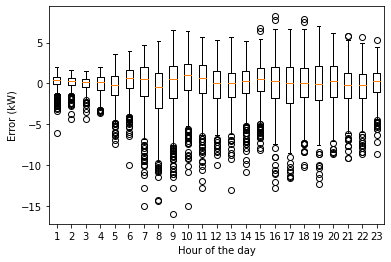

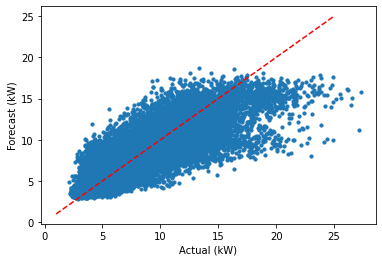

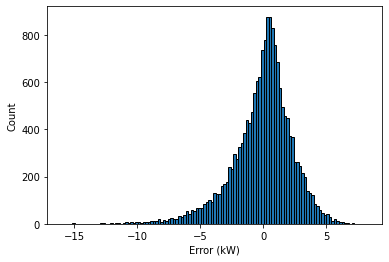

In [105]:
mean_absolute_error(df["crawfordCrescent_F2"],preds)
error = preds - df["crawfordCrescent_F2"]
box_data =[]

for i in range(1,24):
    x = error.values[i*2::48]
    y = error.values[i*2-1::48]
    box_data.append(np.concatenate((x,y)))


plt.boxplot(box_data)
plt.xlabel("Hour of the day")
plt.ylabel("Error (kW)")
#plt.savefig("boxplot.jpg", dpi=300)
plt.show()

plt.scatter(df["crawfordCrescent_F2"], preds,s=10)
plt.plot([1,25], [1,25], c="r",ls="--")
plt.xlabel("Actual (kW)")
plt.ylabel("Forecast (kW)")
#plt.savefig("linear.jpg", dpi=300)
plt.show()

plt.hist(error, bins='auto', edgecolor='black', linewidth=1)
plt.xlabel("Error (kW)")
plt.ylabel("Count")
#plt.savefig("hist.jpg", dpi=300)
plt.show()

In [106]:
peaksReal = []
peaksPred = []
dayLoadsReal = []
dayLoadsPred = []
hourOfPeakReal = []
hourOfPeakPred = []
real = df['crawfordCrescent_F2'].values

n = 48

for i in range(0, len(real), n):
    dayReal = real[i:i + n]
    dayPred = preds[i:i + n]
    dayLoadsReal.append(dayReal)
    dayLoadsPred.append(dayPred)
    peakReal = max(dayReal)
    peakPred = max(dayPred)
    peaksReal.append(peakReal)
    peaksPred.append(peakPred)
    hourOfPeakReal.append(dayReal.argmax())
    hourOfPeakPred.append(dayPred.argmax())

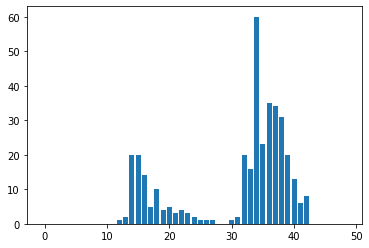

In [107]:
count = []

for i in range(49):
    count.append(hourOfPeakReal.count(i))

plt.bar(range(len(count)), count)
plt.show()